# UNSEEN analysis


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import stability
from unseen import eva
from unseen import general_utils

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
metric = "rx5day"
var = "pr"
metric_plot_label = "rx5day (mm)"
metric_plot_upper_limit = 1500
obs_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/rx5day_AGCD-CSIRO_1901-2024_annual-aug-to-sep_daintree-river.nc"
model_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river.nc"
model_add_bc_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-additive.nc"
model_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-multiplicative.nc"
similarity_add_bc_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/similarity-test_rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-additive.nc"
similarity_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/similarity-test_rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-multiplicative.nc"
similarity_raw_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/similarity-test_rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river_AGCD-CSIRO.nc"
independence_plot = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/independence-test_rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river.png"
stability_plot_empirical = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/stability-test-empirical_rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river.png"
stability_plot_gev = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/stability-test-gev_rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river.png"
moments_add_plot = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/moments-test_rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-additive.png"
moments_mulc_plot = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/moments-test_rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-multiplicative.png"
moments_raw_plot = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/moments-test_rx5day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_daintree-river_AGCD-CSIRO.png"
model_name = "MRI-ESM2-0"
min_lead = 0
region_name = "daintree-river"
shape_file = (
    "/g/data/xv83/unseen-projects/outputs/tc-jasper/shapefiles/daintree_river.shp"
)
shape_overlap = 0.001
file_list = "/g/data/xv83/unseen-projects/code/file_lists/MRI-ESM2-0_dcppA-hindcast_pr_files.txt"


In [4]:
# Required parameters
assert 'metric' in locals(), "Must provide a metric name"
assert 'var' in locals(), "Must provide a variable name"
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert 'shape_overlap' in locals(), "Must provide a shape overlap fraction"
assert 'metric_plot_label' in locals(), "Must provide a plot axis label for the metric"
assert 'metric_plot_upper_limit' in locals(), "Must provide an upper limit for the metric value"
assert os.path.isfile(obs_file), "Must provide an observations data file (papermill option -p obs_file [filepath])"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"
assert os.path.isfile(stability_plot_empirical), "Must provide an empirical stability test plot (papermill option -p stability_plot_empirical [filepath])"
assert os.path.isfile(stability_plot_gev), "Must provide a GEV stability test plot (papermill option -p stability_plot_gev [filepath])"
assert os.path.isfile(moments_add_plot), "Must provide a moments test plot for the additive bias corrected data (papermill option -p moments_add_plot [filepath])"
assert os.path.isfile(moments_mulc_plot), "Must provide a moments test plot for the multiplicative bias corrected data (papermill option -p moments_mulc_plot [filepath])"
assert os.path.isfile(moments_raw_plot), "Must provide a moments test plot for the raw data (papermill option -p moments_raw_plot [filepath])"


In [5]:
units_dict = {
    'pr': 'mm day-1'
}

## Observations

In [6]:
obs_ds = fileio.open_dataset(obs_file)
obs_ds = obs_ds.dropna('time')

In [7]:
years = obs_ds['time'].dt.year.values
obs_df = pd.DataFrame(index=years)
obs_df[var] = obs_ds[var].values

In [8]:
obs_max_event = obs_ds['pr'].values.max()
print(obs_max_event)

1459.442


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/MRI/MRI-ESM2-0/dcppA-hindcast/s1960-r1i1p1f1/day/pr/gn/v20210122/pr_day_MRI-ESM2-0_dcppA-hindcast_s1960-r1i1p1f1_gn_19601101-19651231.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/g/data/xv83/unseen-projects/code/dataset_config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [15]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=[var],
    lat_bnds=[-44, -10],
    lon_bnds=[113, 155],
#    shapefile=shape_file,
#    shape_overlap=shape_overlap,
    units={var: units_dict[var]},
    isel=isel_dict,
)

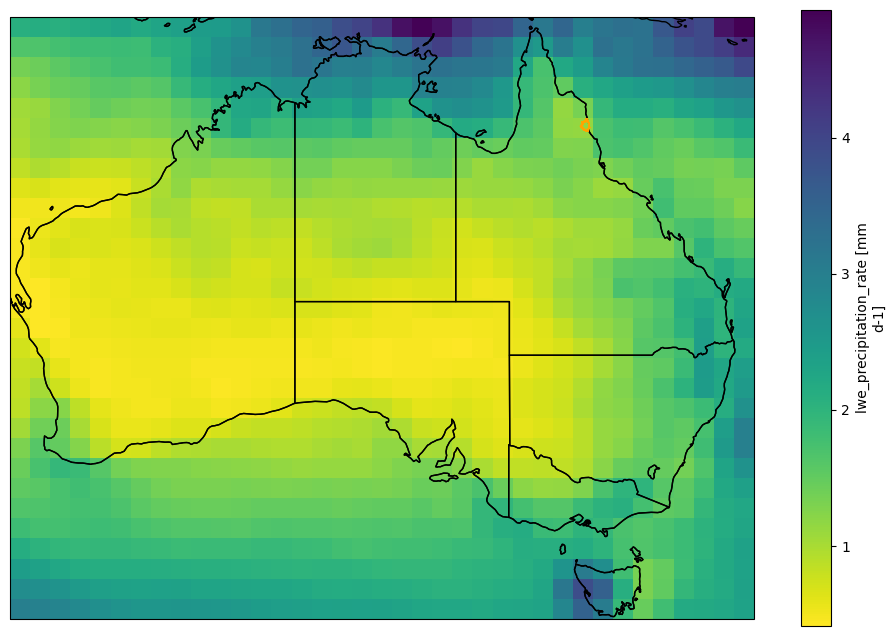

In [16]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds[var].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [17]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [18]:
model_ds

<xarray.Dataset>
Dimensions:     (init_date: 60, ensemble: 10, lead_time: 6)
Coordinates:
  * lead_time   (lead_time) int64 0 1 2 3 4 5
    event_time  (init_date, ensemble, lead_time) object dask.array<chunksize=(60, 10, 6), meta=np.ndarray>
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * init_date   (init_date) object 1960-11-01 00:00:00 ... 2019-11-01 00:00:00
    time        (lead_time, init_date) object dask.array<chunksize=(6, 60), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(60, 10, 6), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          standard
    branch_time_in_child:   40481.0
    branch_time_in_parent:  40481.0
    creation_date:          2021-01-10T03:27:09Z
    ...                     ...
    title:                  MRI-ESM2-0 output prepared for CMIP6
    variable_id:            pr
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MRI is licensed unde...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/d5249c9d-01a4-4e2d-83c5-47bc7da26c63

### Independence testing

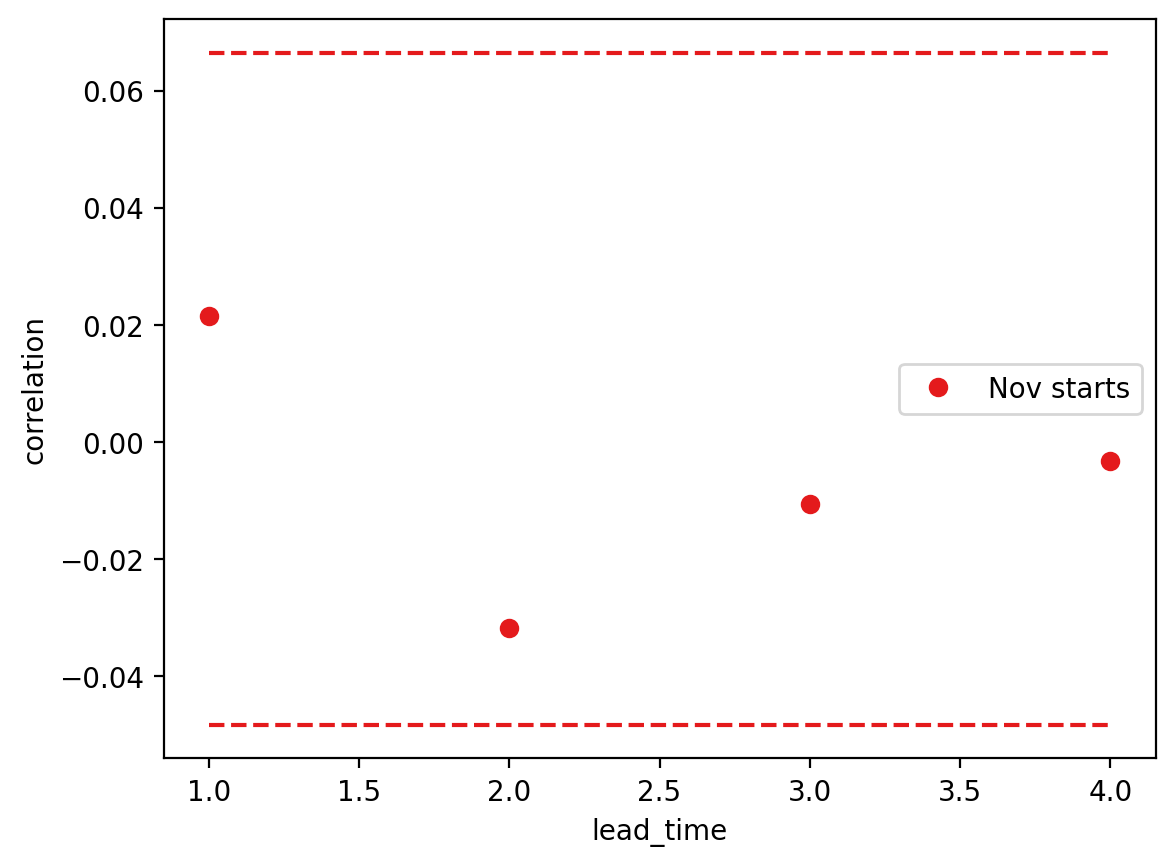

In [19]:
Image(filename=independence_plot)

In [20]:
print(min_lead)

0


In [21]:
model_da = model_ds[var].where(model_ds['lead_time'] >= min_lead)

In [22]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
model_da_stacked.shape

(2400,)

In [24]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')[var].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
model_add_bc_da_stacked.shape

(2400,)

In [26]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')[var].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [27]:
model_mulc_bc_da_stacked.shape

(2400,)

### Stability testing

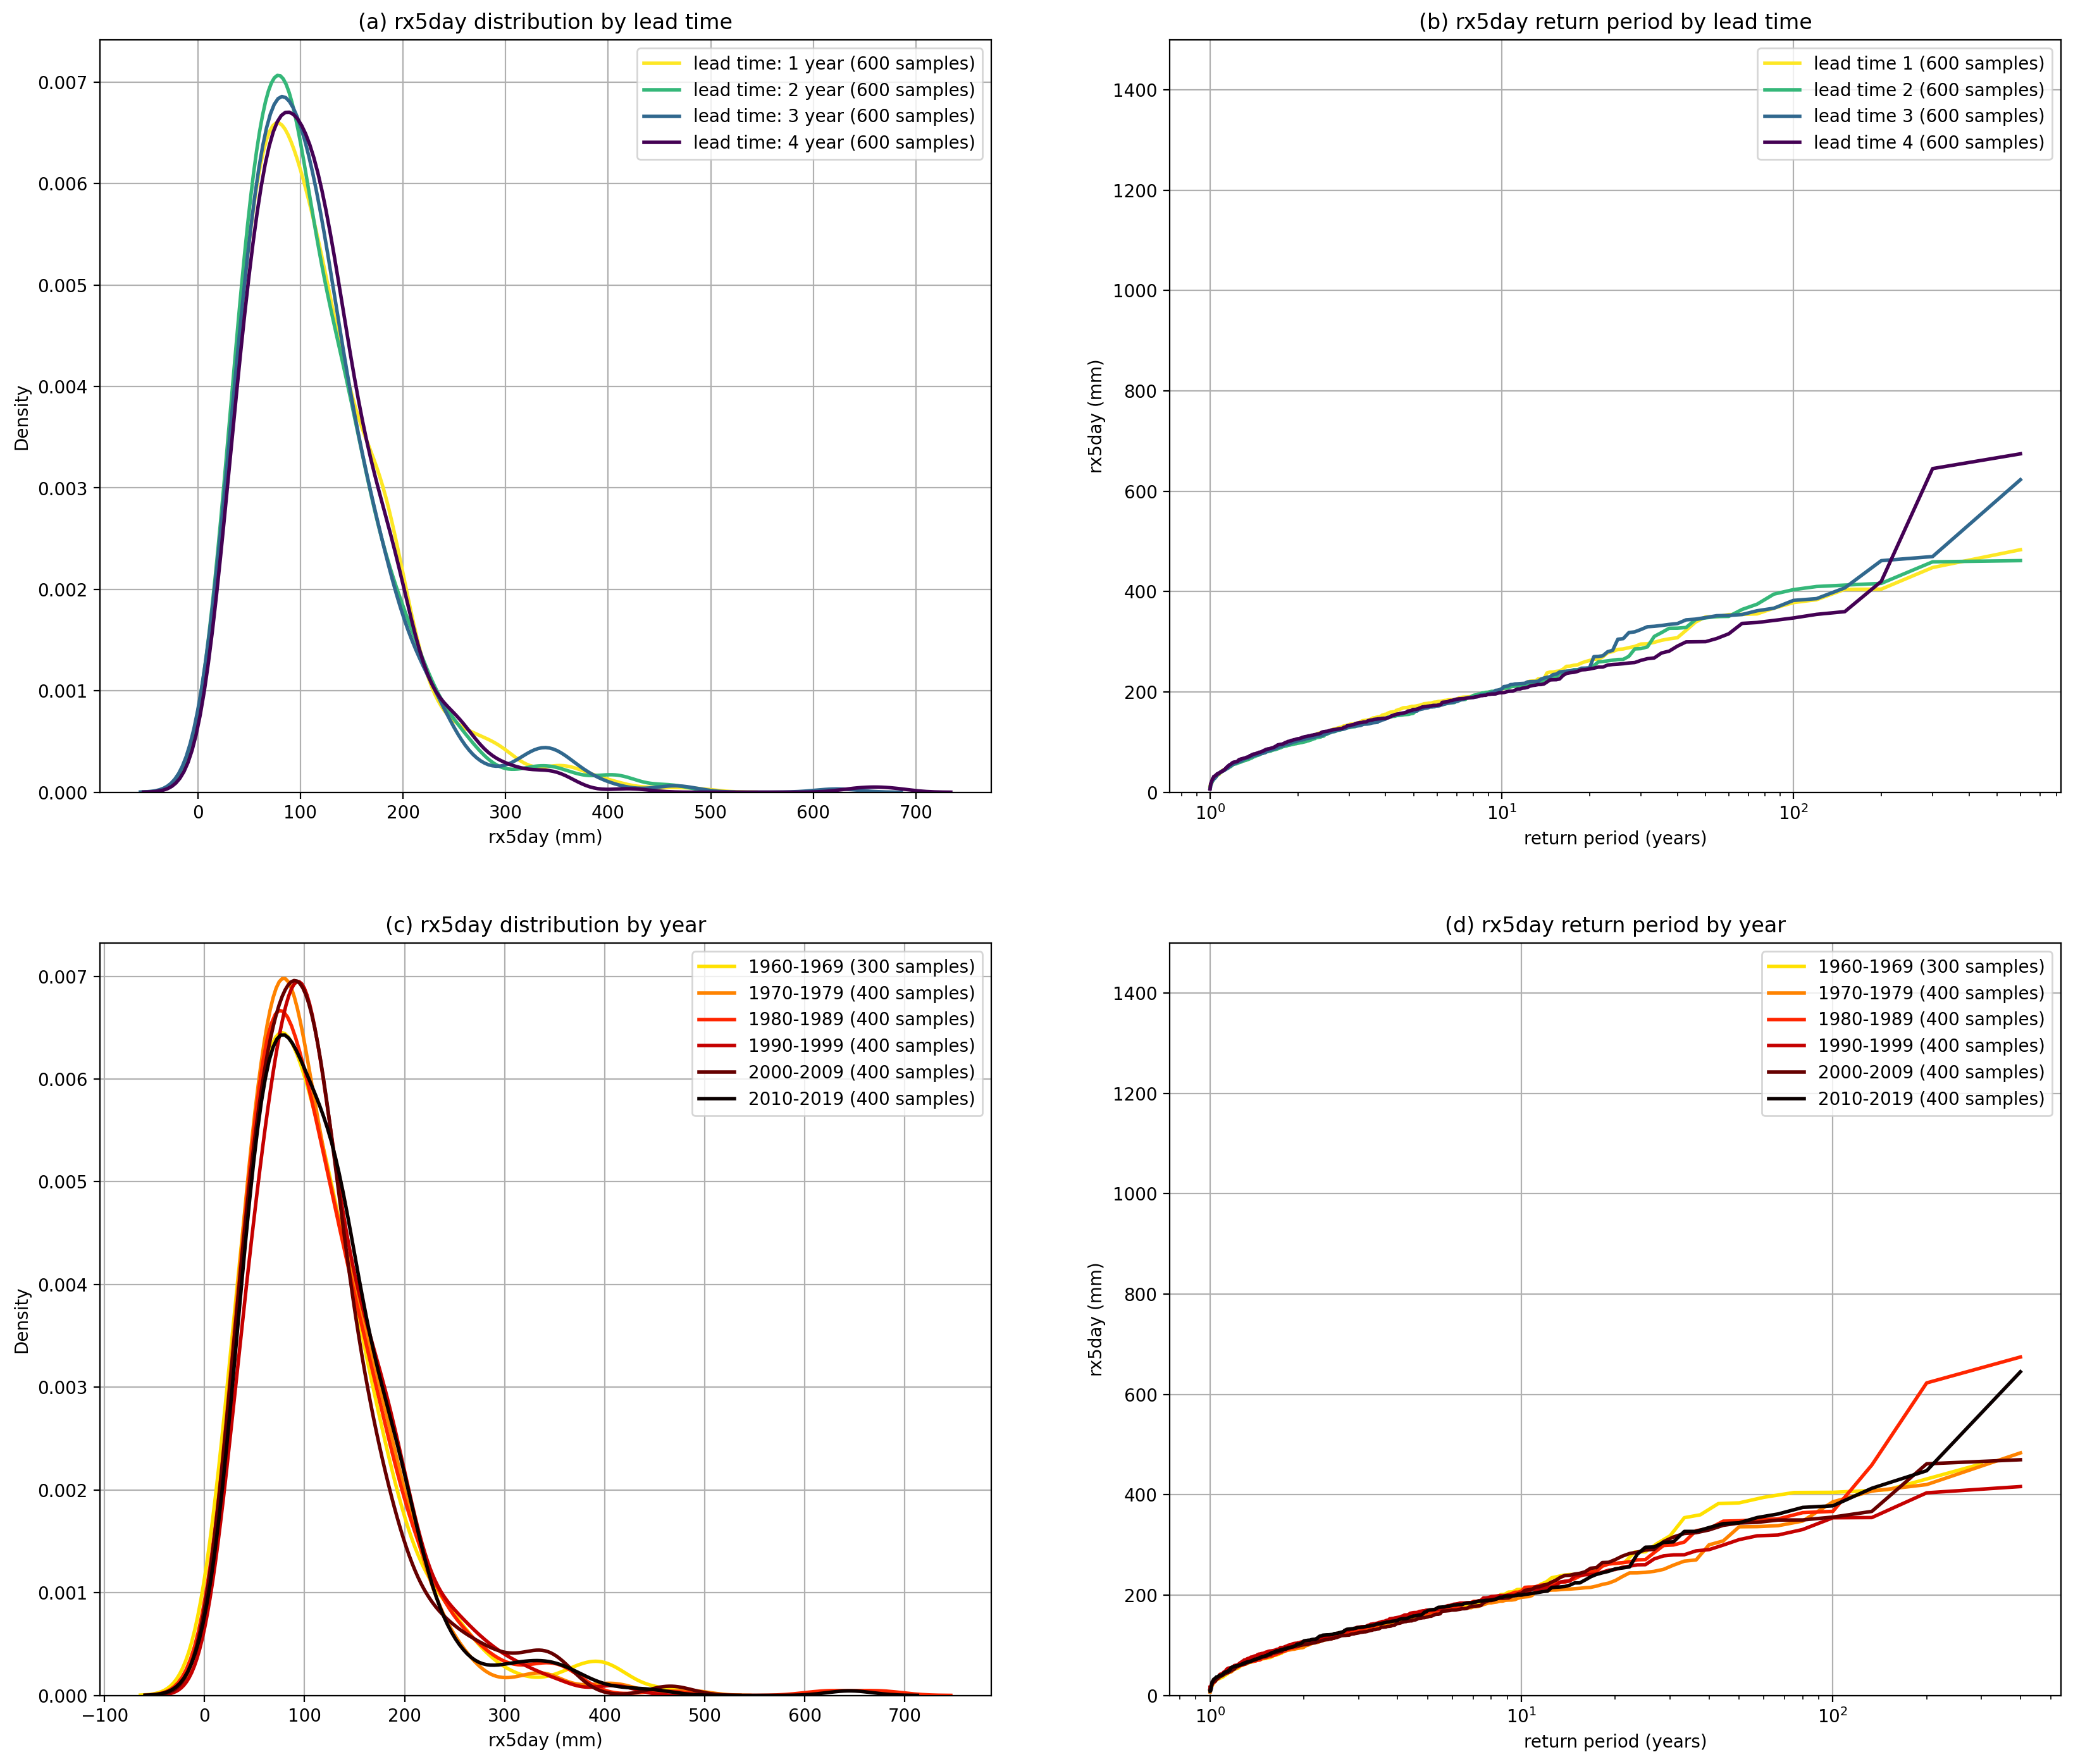

In [28]:
Image(filename=stability_plot_empirical)

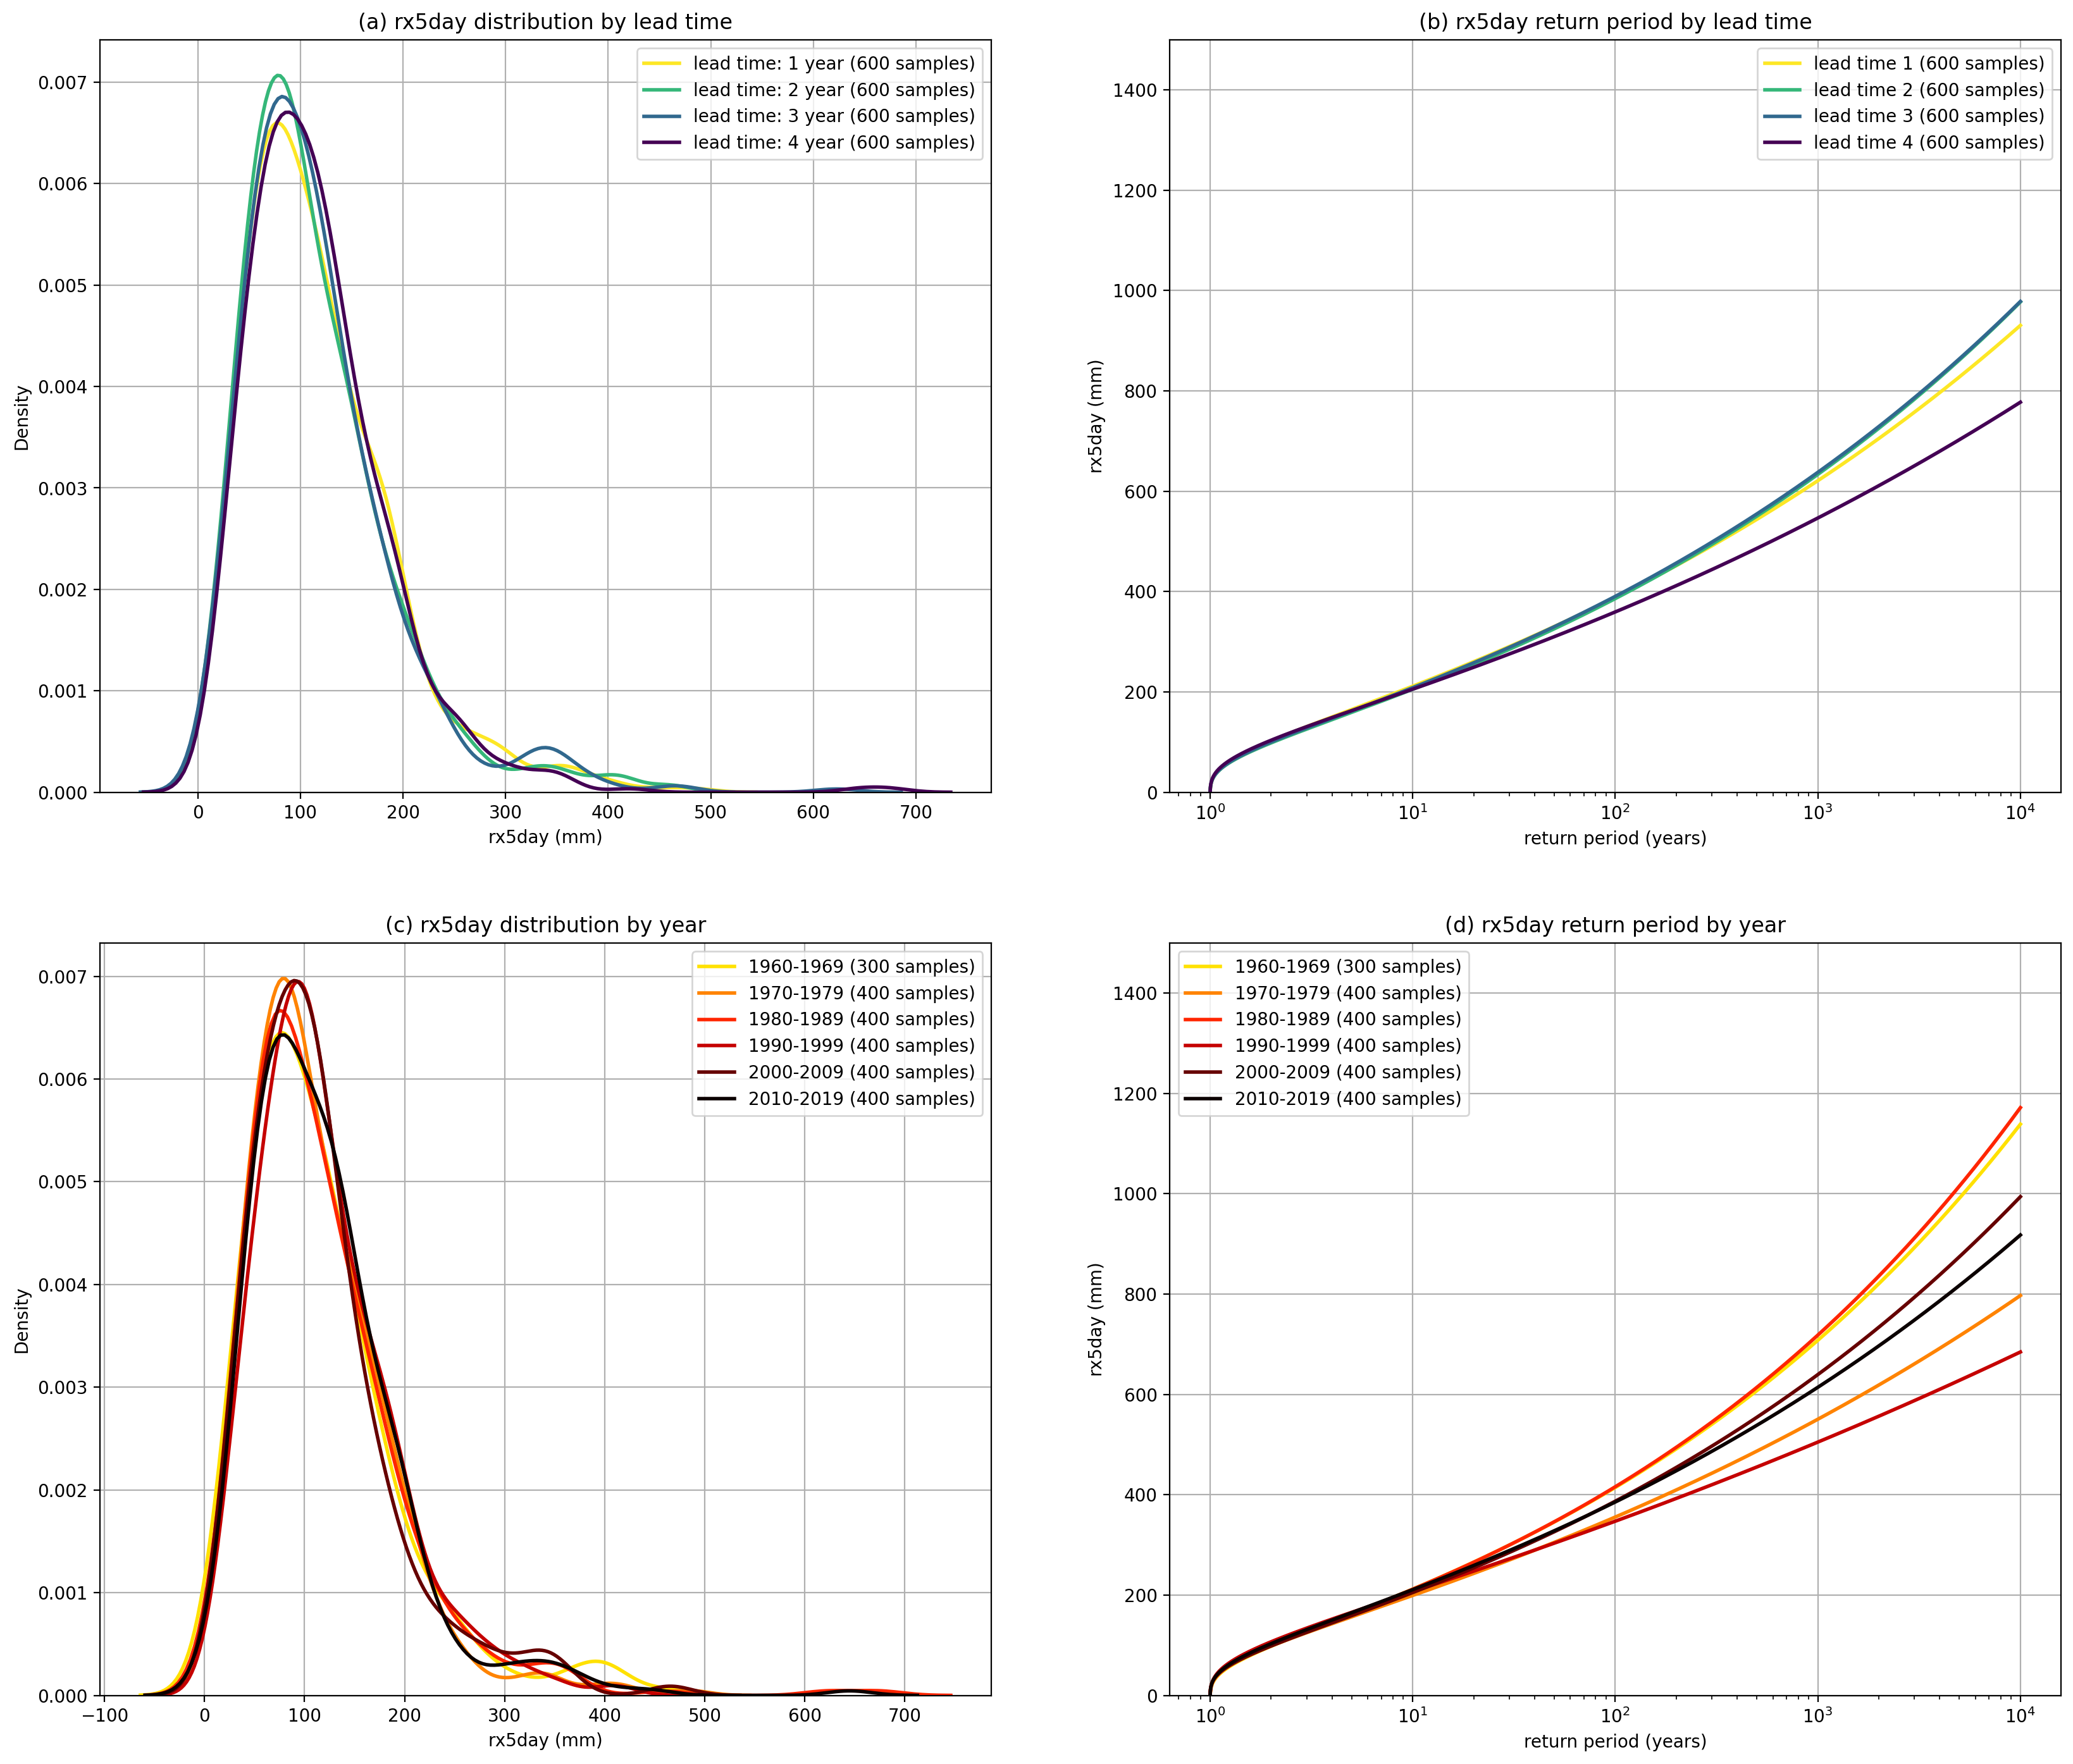

In [29]:
Image(filename=stability_plot_gev)

### Bias correction and similarity testing

In [30]:
model_gev_shape, model_gev_loc, model_gev_scale = eva.fit_gev(model_da_stacked.values)
model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = eva.fit_gev(model_add_bc_da_stacked.values)
model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = eva.fit_gev(model_mulc_bc_da_stacked.values)

/home/599/dbi599/unseen/unseen/eva.py:254: UserWarning: Data fit failed. Retrying with 'generate_estimates=True'.
  warnings.warn(


In [31]:
def plot_distributions(include_additive=False):
    """Plot various distributions"""

    fig = plt.figure(figsize=[10, 6])
    gev_xvals = np.arange(0, metric_plot_upper_limit)

    model_da.plot.hist(
        bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
    )
    model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
    plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

    if include_additive:
        model_add_bc_ds[var].plot.hist(
            bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:red', alpha=0.7
        )
        model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
        plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:red', linewidth=4.0)

    model_mulc_bc_ds[var].plot.hist(
        bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:orange', alpha=0.7
    )
    model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
    plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:orange', linewidth=4.0)

    obs_ds[var].plot.hist(
        bins=50, density=True, label='observations', facecolor='tab:gray', alpha=0.7
    )
    obs_gev_shape, obs_gev_loc, obs_gev_scale = eva.fit_gev(obs_ds[var].values, user_estimates=[-0.11, 293.6, 122.19])
    obs_gev_pdf = gev.pdf(gev_xvals, obs_gev_shape, obs_gev_loc, obs_gev_scale)
    plt.plot(gev_xvals, obs_gev_pdf, color='tab:gray', linewidth=4.0)

    plt.xlabel(metric_plot_label)
    plt.ylabel('probability')
    plt.title(f'{metric} for {region_name} ({model_name})')
    plt.xlim(0, metric_plot_upper_limit)
    plt.legend()
    #if not include_additive:
    #    outfile = f'/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/{metric}_histogram_{model_name}_{region_name}.png'
    #    print(outfile)
    #    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()

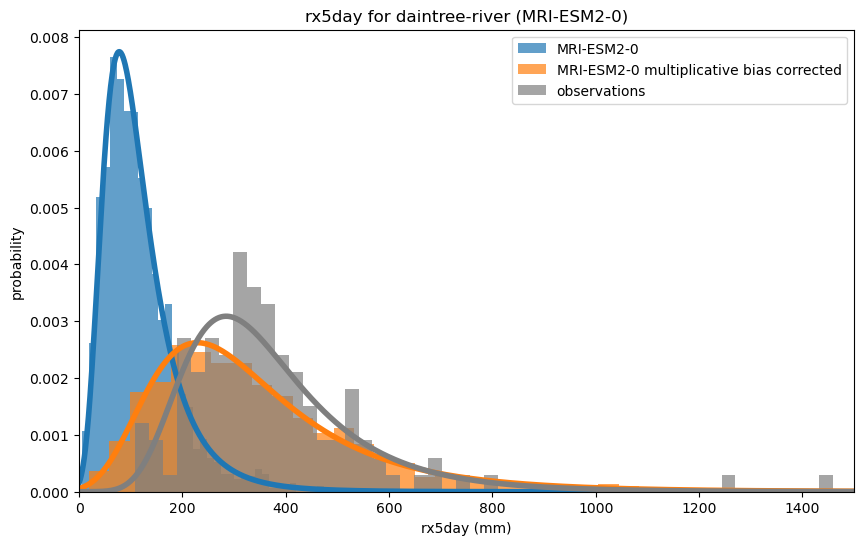

In [32]:
plot_distributions()

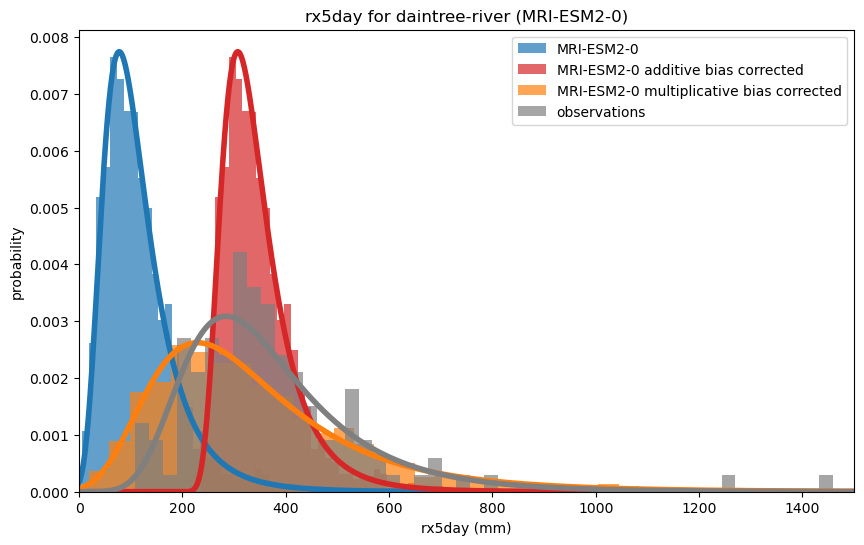

In [33]:
plot_distributions(include_additive=True)

In [34]:
print(f'raw data shape parameter: {model_gev_shape:.3f}')
print(f'raw data location parameter: {model_gev_loc:.3f}') 
print(f'raw data scale parameter: {model_gev_scale:.3f}')

raw data shape parameter: -0.125
raw data location parameter: 83.138
raw data scale parameter: 47.877


In [35]:
print(f'additive corrected shape parameter: {model_add_bc_gev_shape:.3f}')
print(f'additive corrected location parameter: {model_add_bc_gev_loc:.3f}') 
print(f'additive corrected scale parameter: {model_add_bc_gev_scale:.3f}')

additive corrected shape parameter: -0.125
additive corrected location parameter: 312.572
additive corrected scale parameter: 47.877


In [36]:
print(f'multiplicative corrected shape parameter: {model_mulc_bc_gev_shape:.3f}')
print(f'multiplicative corrected location parameter: {model_mulc_bc_gev_loc:.3f}') 
print(f'multiplicative corrected scale parameter: {model_mulc_bc_gev_scale:.3f}')

multiplicative corrected shape parameter: -0.125
multiplicative corrected location parameter: 245.474
multiplicative corrected scale parameter: 141.362


We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [37]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [38]:
similarity_raw_ds['ks_statistic'].values

array(0.8053704, dtype=float32)

In [39]:
similarity_raw_ds['ks_pval'].values

array(2.906712e-37, dtype=float32)

In [40]:
similarity_raw_ds['ad_statistic'].values

array(139.85226, dtype=float32)

In [41]:
similarity_raw_ds['ad_pval'].values

array(0.001, dtype=float32)

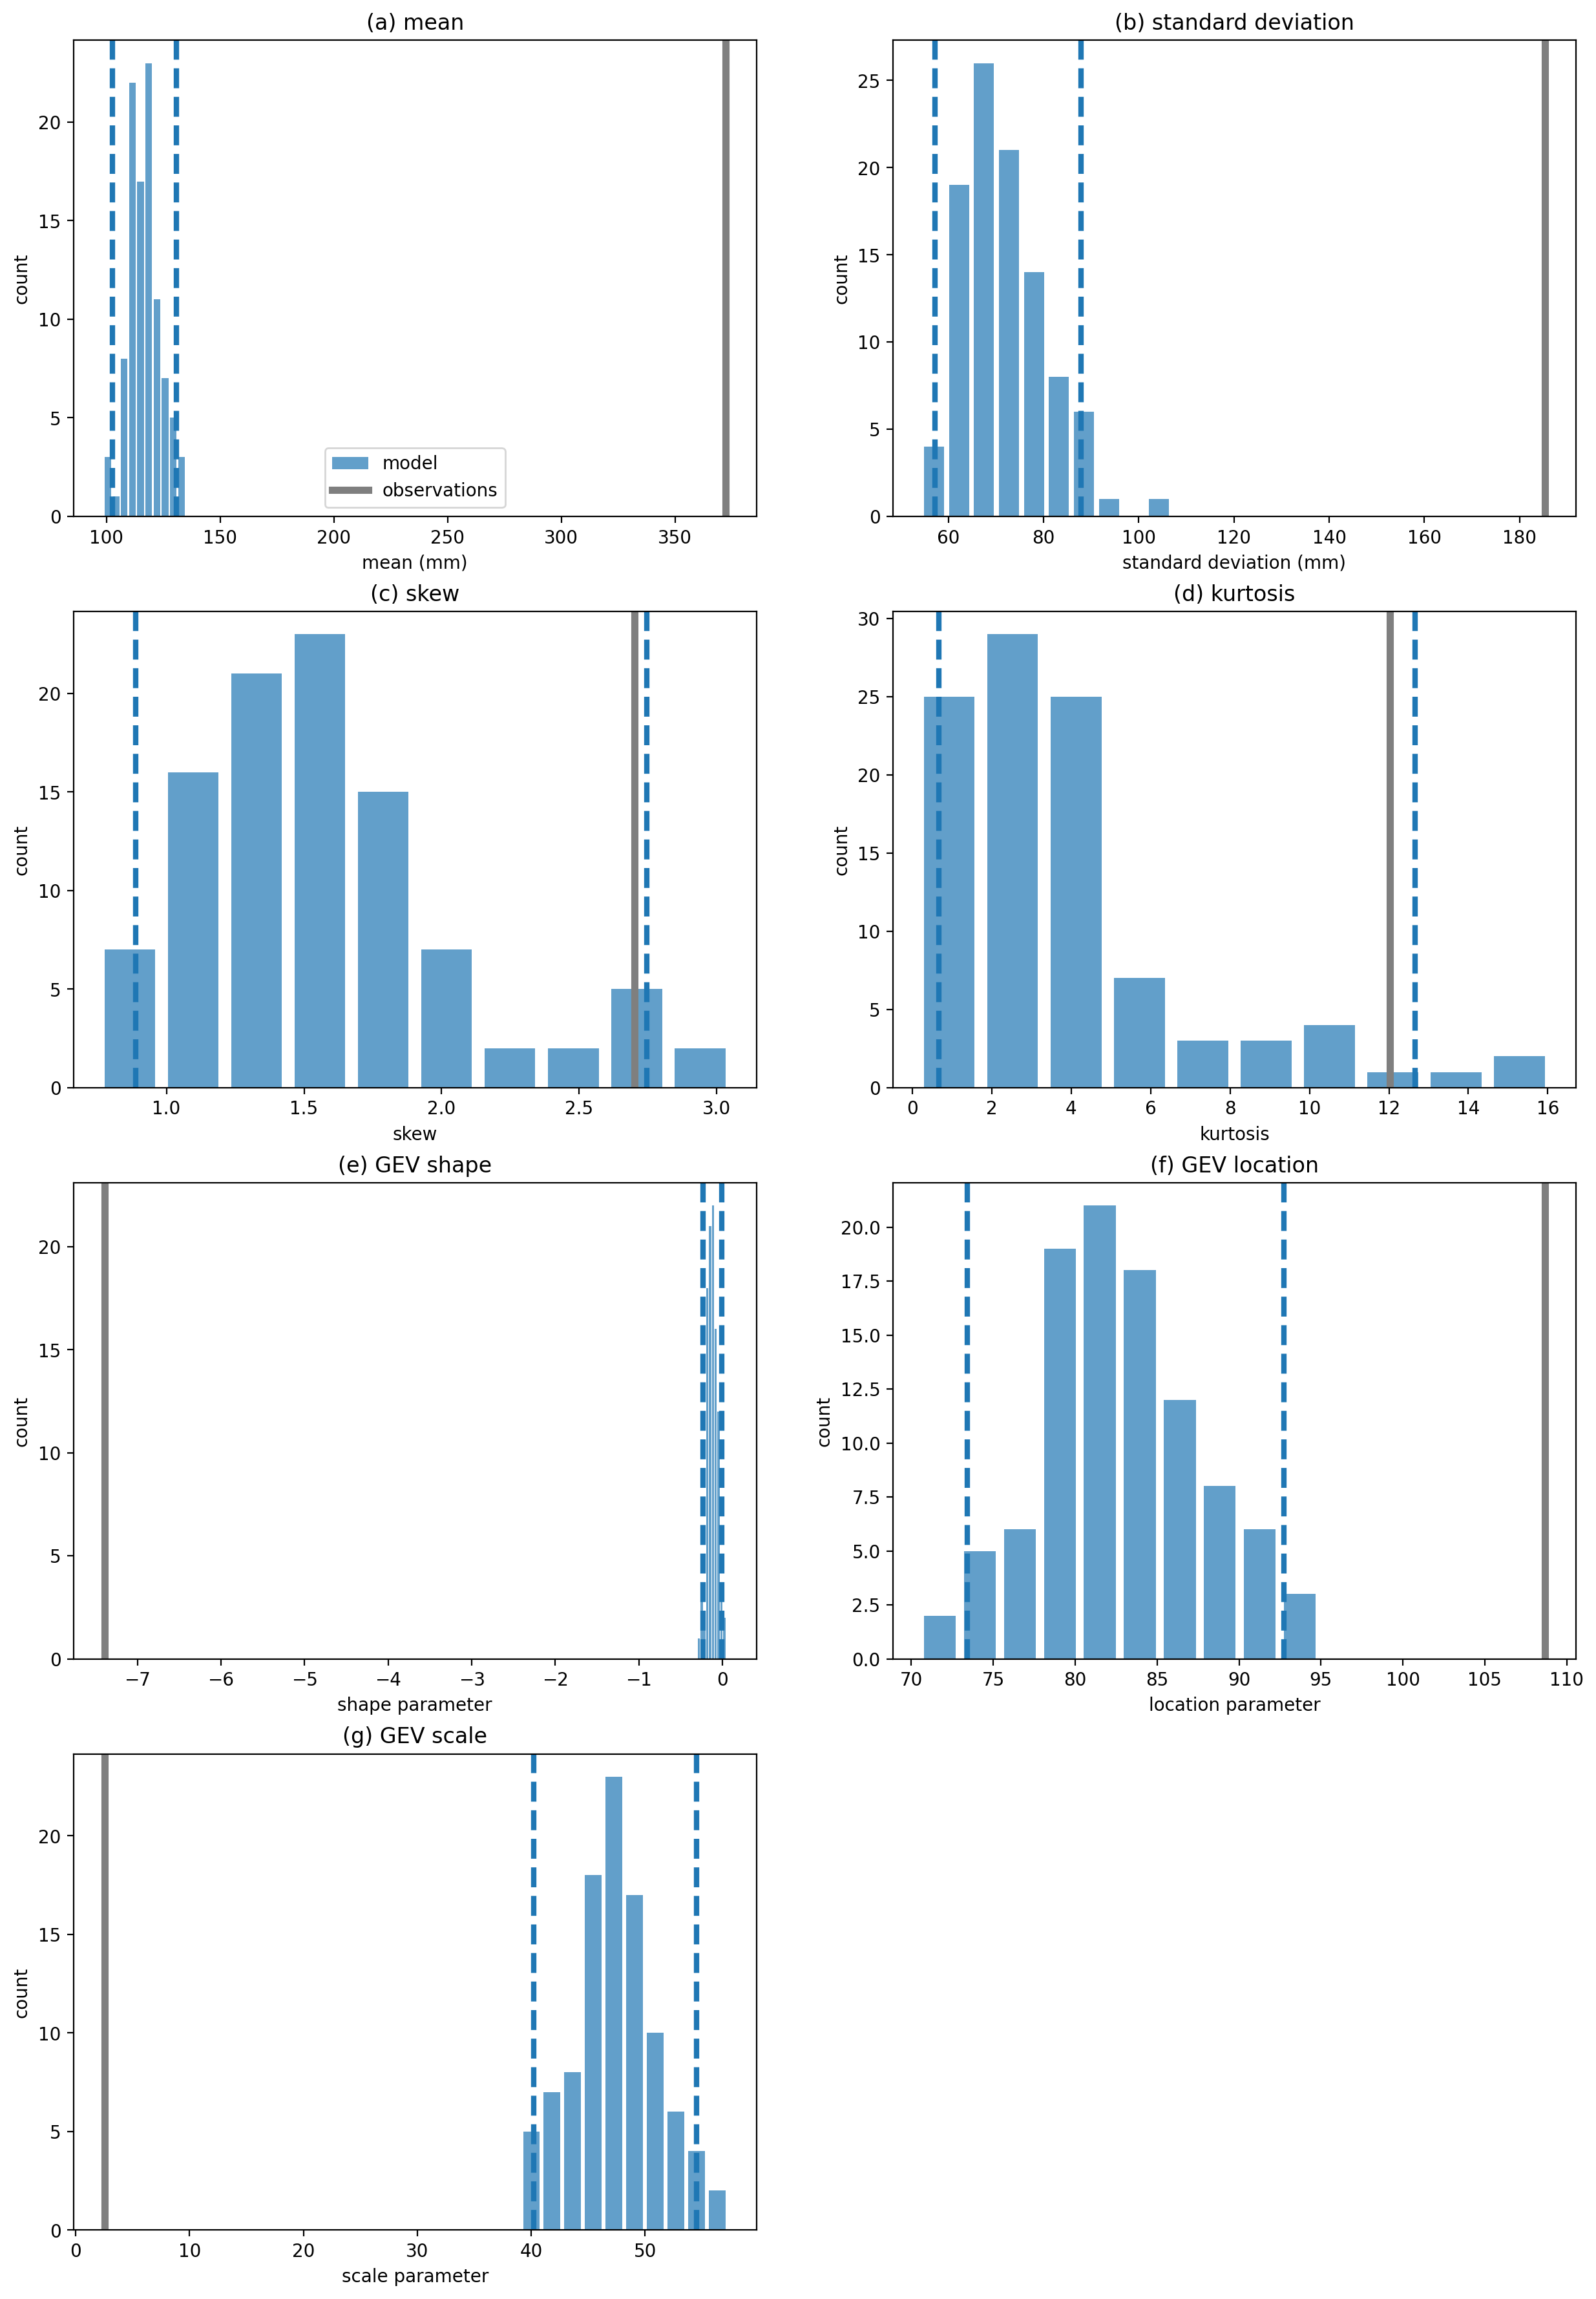

In [42]:
Image(filename=moments_raw_plot)

In [43]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)

In [44]:
similarity_add_bias_ds['ks_statistic'].values

array(0.16393518, dtype=float32)

In [45]:
similarity_add_bias_ds['ks_pval'].values

array(0.10416234, dtype=float32)

In [46]:
similarity_add_bias_ds['ad_statistic'].values

array(7.5469236, dtype=float32)

In [47]:
similarity_add_bias_ds['ad_pval'].values

array(0.001, dtype=float32)

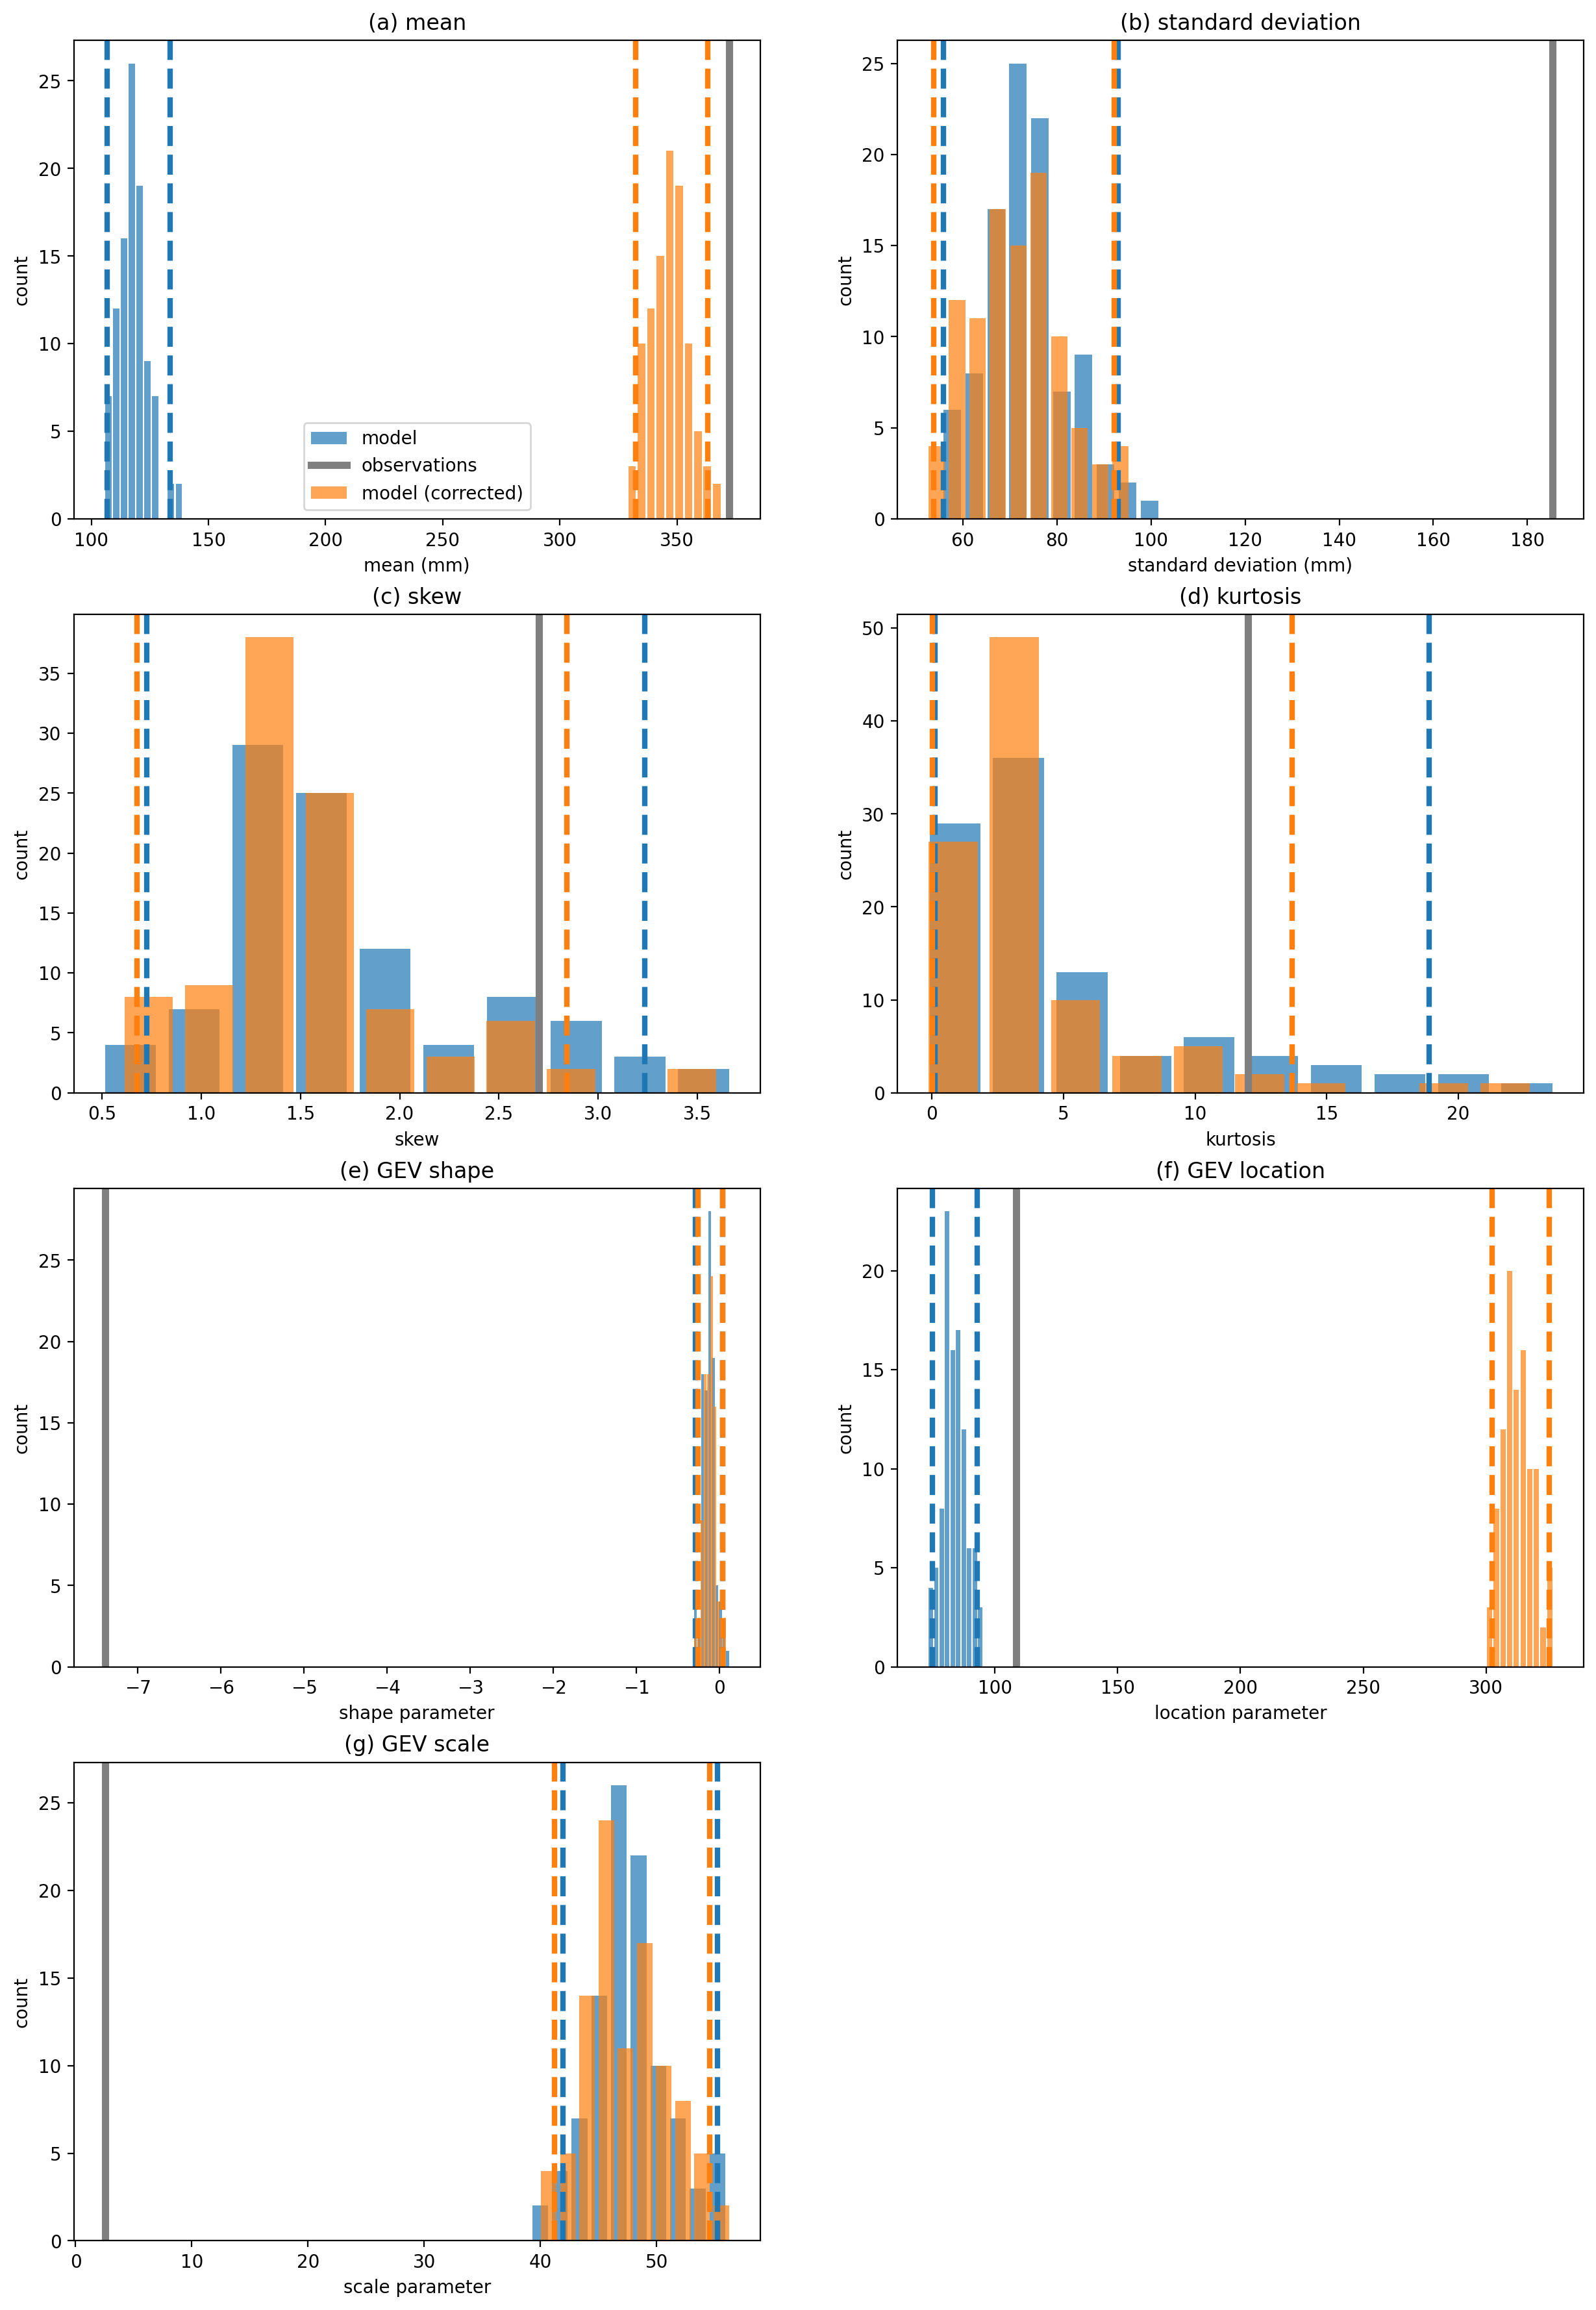

In [48]:
Image(filename=moments_add_plot)

In [49]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)

In [50]:
similarity_mulc_bias_ds['ks_statistic'].values

array(0.23018518, dtype=float32)

In [51]:
similarity_mulc_bias_ds['ks_pval'].values

array(0.00607758, dtype=float32)

In [52]:
similarity_mulc_bias_ds['ad_statistic'].values

array(3.3856552, dtype=float32)

In [53]:
similarity_mulc_bias_ds['ad_pval'].values

array(0.01380563, dtype=float32)

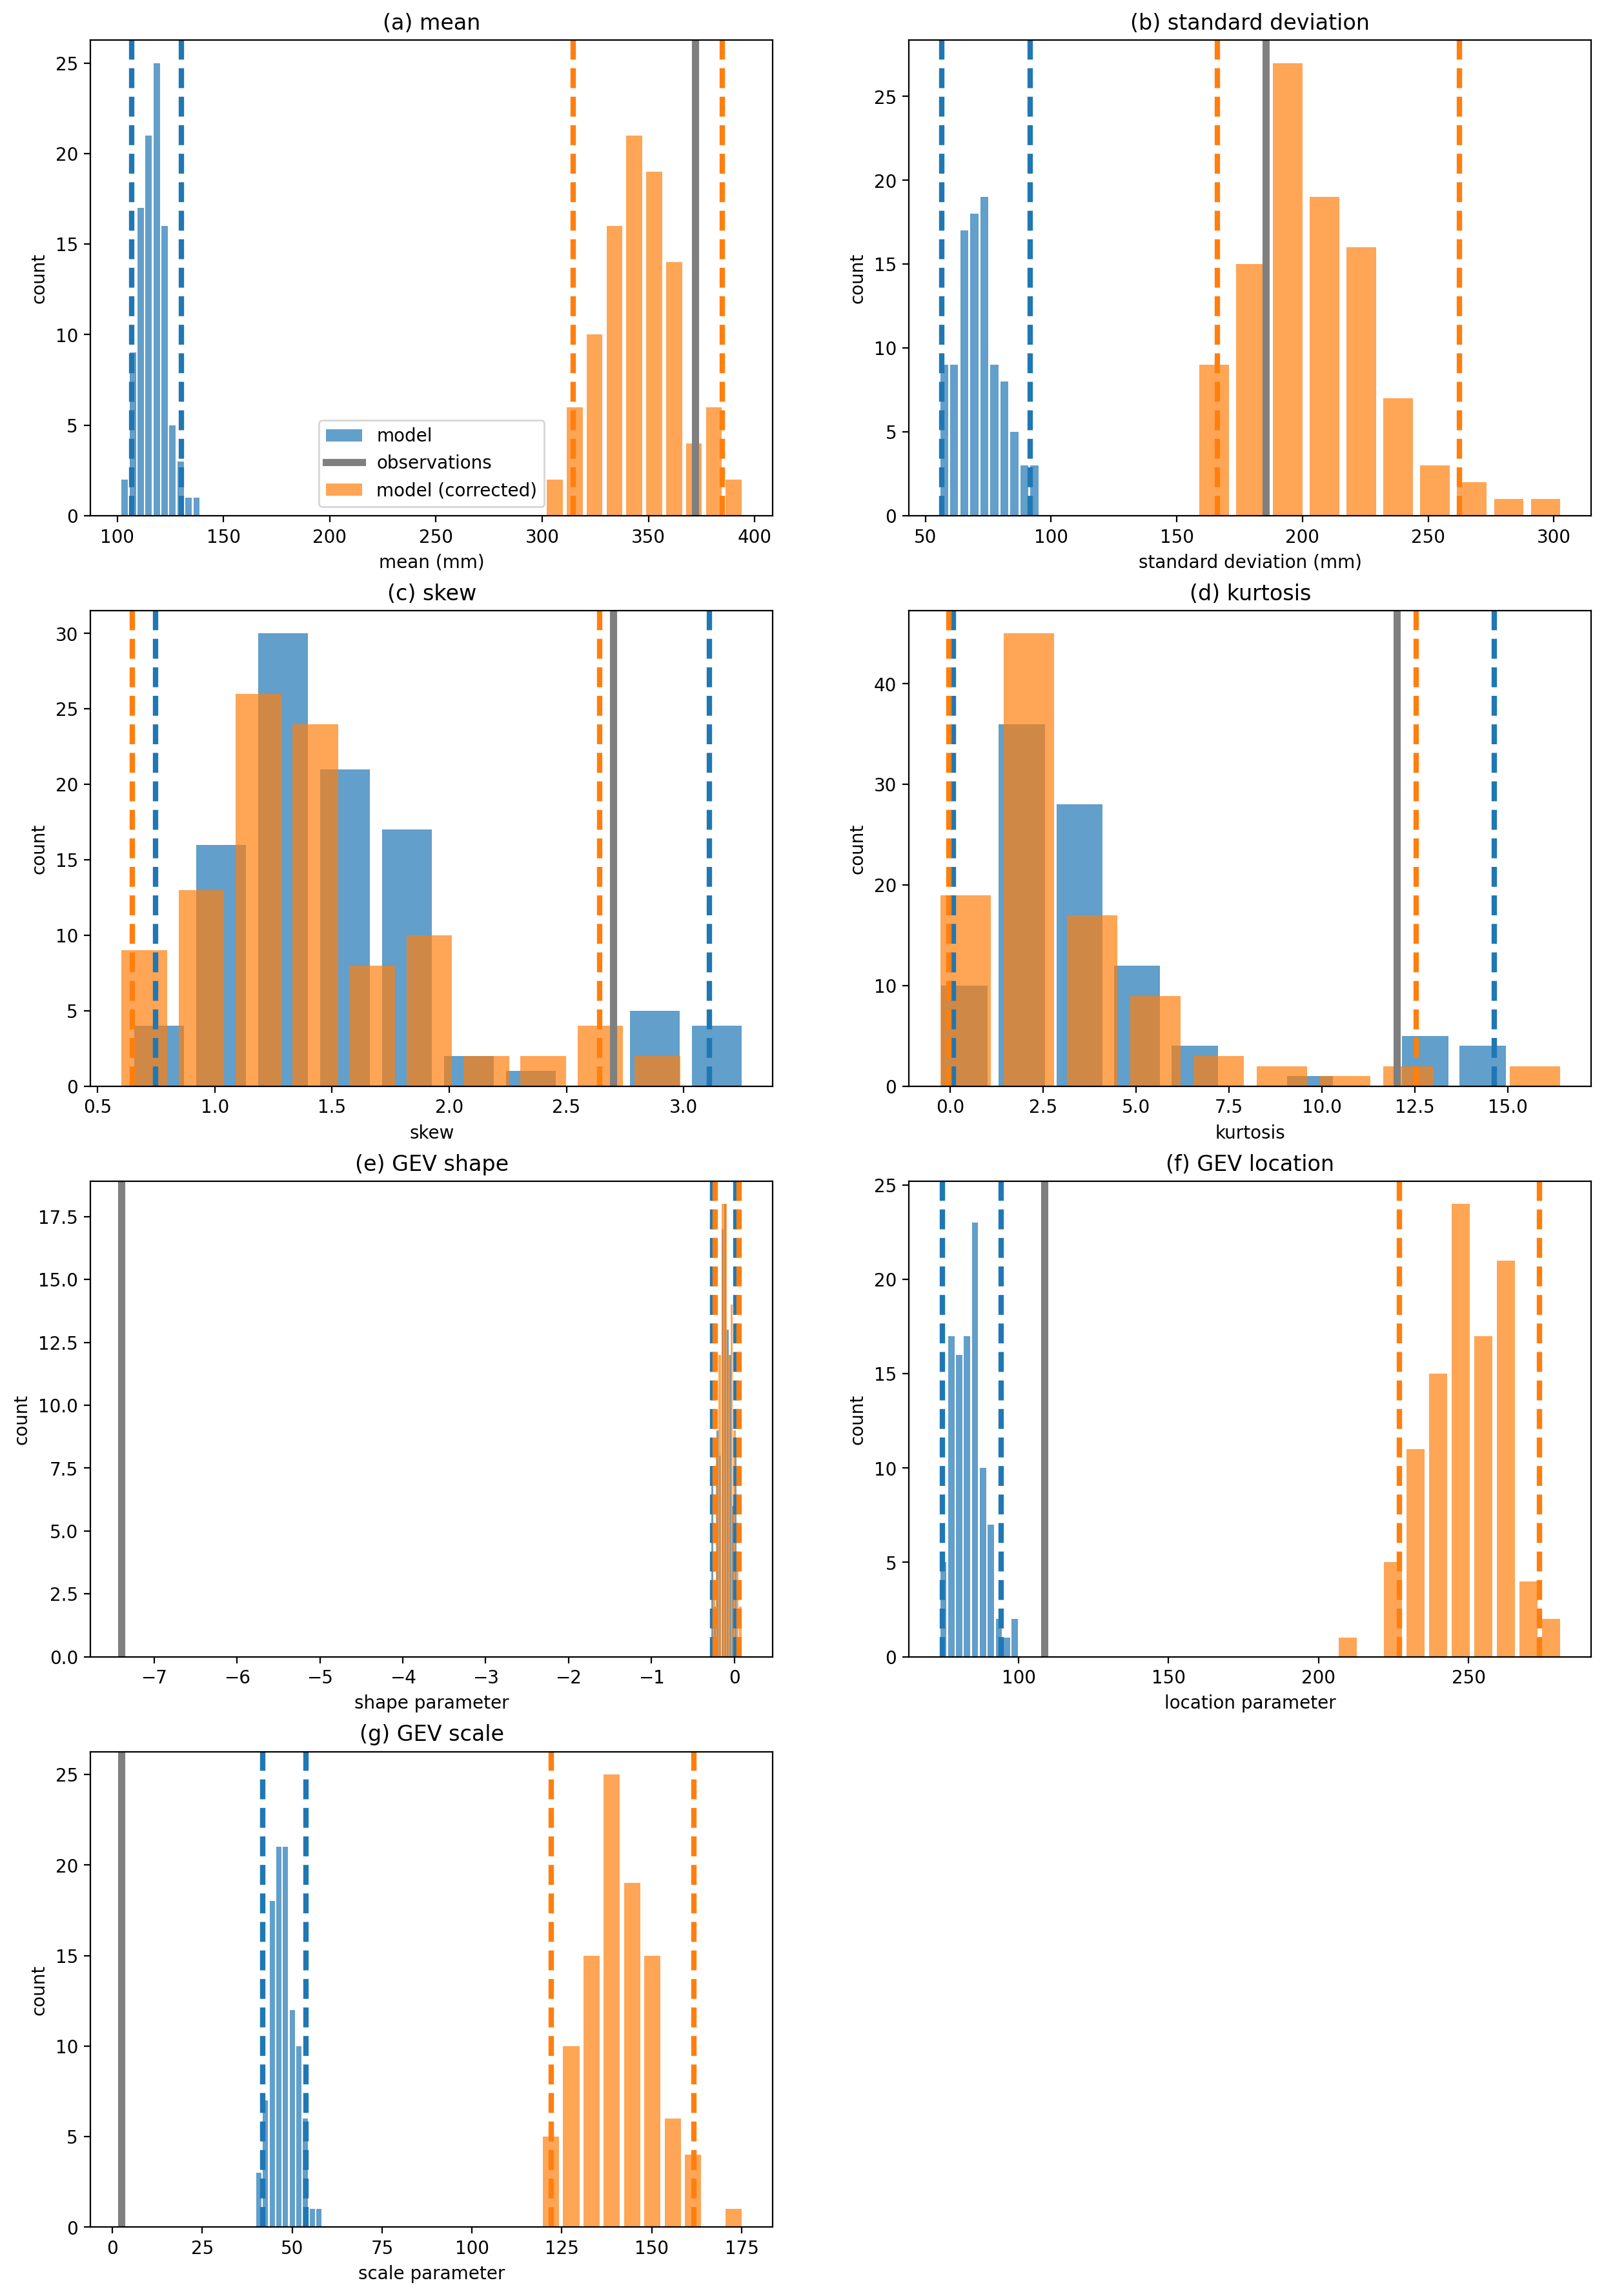

In [54]:
Image(filename=moments_mulc_plot)

### Return curves

In [55]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

#### Additive bias corrected data

In [56]:
n_events_add_bc, n_population_add_bc, return_period_add_bc, percentile_add_bc = eva.event_in_context(
    model_add_bc_da_stacked.values,
    obs_max_event,
    'above',
)
print('ADDITIVE BIAS CORRECTED DATA')
print(f'{n_events_add_bc} events in {n_population_add_bc} samples')
print(f'{percentile_add_bc:.2f}% percentile')
print(f'{return_period_add_bc:.0f} year return period')

ADDITIVE BIAS CORRECTED DATA
0 events in 2400 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/eva.py:44: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [57]:
print('ADDITIVE BIAS CORRECTED GEV')
gev_event_likelihood(obs_max_event, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)

ADDITIVE BIAS CORRECTED GEV
100.00% percentile
65332 year return period



#### Multiplicative bias corrected data

ValueError: tuple.index(x): x not in tuple

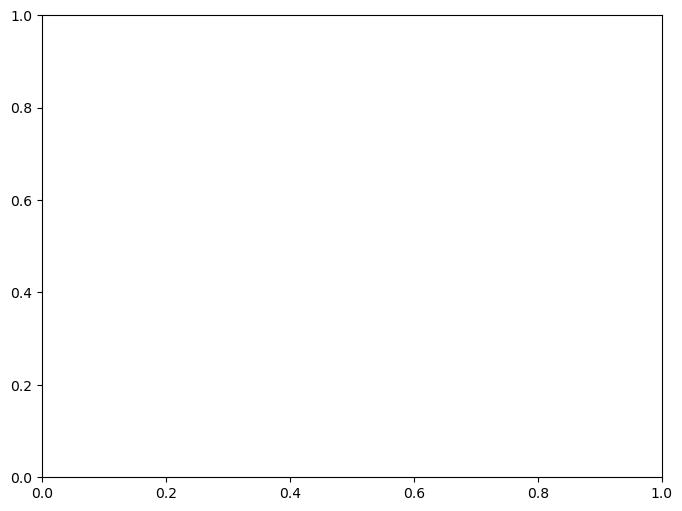

In [58]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
eva.plot_gev_return_curve(
    ax,
    model_mulc_bc_da_stacked,
    obs_max_event,
    bootstrap_method='non-parametric',
    n_bootstraps=1000,
    ylabel=metric_plot_label,
    ylim=[50, metric_plot_upper_limit],
    text=True,
)
#outfile = f'/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/{metric}_return-curve_{model_name}_{region_name}.png'
#print(outfile)
#plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [71]:
n_events_mulc_bc, n_population_mulc_bc, return_period_mulc_bc, percentile_mulc_bc = eva.event_in_context(model_add_bc_da_stacked.values, obs_max_event, 'above')
print('MULTIPLICATIVE BIAS CORRECTED DATA')
print(f'{n_events_mulc_bc} events in {n_population_mulc_bc} samples')
print(f'{percentile_mulc_bc:.2f}% percentile')
print(f'{return_period_mulc_bc:.0f} year return period')

MULTIPLICATIVE BIAS CORRECTED DATA
0 events in 2400 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/eva.py:44: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [72]:
print('MULTIPLICATIVE BIAS CORRECTED GEV')
gev_event_likelihood(obs_max_event, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)

MULTIPLICATIVE BIAS CORRECTED GEV
99.71% percentile
343 year return period



#### Raw data

In [59]:
n_events, n_population, return_period, percentile = eva.event_in_context(model_da_stacked.values, obs_max_event, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 2400 samples
100.00% percentile
inf year return period


In [60]:
print('RAW GEV')
gev_event_likelihood(obs_max_event, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
100.00% percentile
200080 year return period



### Seasonality

In [61]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()

In [62]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

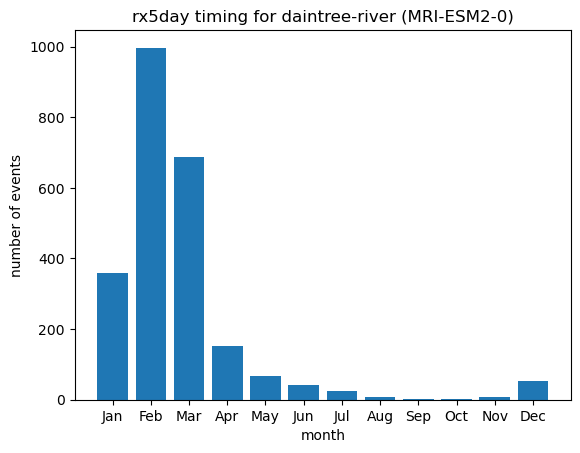

In [63]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'{metric} timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#outfile = f'/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/{metric}_timing_{model_name}_{region_name}.png'
#print(outfile)
#plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

### Meteorology

In [64]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [65]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

event_time                 time  \
ensemble init_date           lead_time                                    
2        1985-11-01 00:00:00 4          1990-03-12  1989-11-01 12:00:00   
4        2009-11-01 00:00:00 4          2014-03-17  2013-11-01 12:00:00   
5        1986-11-01 00:00:00 3          1990-03-09  1989-11-01 12:00:00   
4        1971-11-01 00:00:00 1          1973-02-14  1972-10-31 12:00:00   
8        2000-11-01 00:00:00 3          2004-03-13  2003-11-02 12:00:00   
7        2004-11-01 00:00:00 2          2007-03-01  2006-11-01 12:00:00   
3        1960-11-01 00:00:00 3          1964-02-24  1963-11-02 12:00:00   
         1978-11-01 00:00:00 2          1981-03-20  1980-11-01 12:00:00   
6        2011-11-01 00:00:00 1          2013-03-20  2012-10-31 12:00:00   
4        1973-11-01 00:00:00 4          1978-03-09  1977-11-01 12:00:00   

                                        ensemble            init_date  \
ensemble init_date           lead_time                                  
2        1985-11-01 00:00:00 4                 2  1985-11-01 00:00:00   
4        2009-11-01 00:00:00 4                 4  2009-11-01 00:00:00   
5        1986-11-01 00:00:00 3                 5  1986-11-01 00:00:00   
4        1971-11-01 00:00:00 1                 4  1971-11-01 00:00:00   
8        2000-11-01 00:00:00 3                 8  2000-11-01 00:00:00   
7        2004-11-01 00:00:00 2                 7  2004-11-01 00:00:00   
3        1960-11-01 00:00:00 3                 3  1960-11-01 00:00:00   
         1978-11-01 00:00:00 2                 3  1978-11-01 00:00:00   
6        2011-11-01 00:00:00 1                 6  2011-11-01 00:00:00   
4        1973-11-01 00:00:00 4                 4  1973-11-01 00:00:00   

                                        lead_time          pr  
ensemble init_date           lead_time                         
2        1985-11-01 00:00:00 4                  4  674.396925  
4        2009-11-01 00:00:00 4                  4  644.948353  
5        1986-11-01 00:00:00 3                  3  622.785027  
4        1971-11-01 00:00:00 1                  1  483.280119  
8        2000-11-01 00:00:00 3                  3  469.656573  
7        2004-11-01 00:00:00 2                  2  461.548789  
3        1960-11-01 00:00:00 3                  3  461.427841  
         1978-11-01 00:00:00 2                  2  459.139951  
6        2011-11-01 00:00:00 1                  1  447.774919  
4        1973-11-01 00:00:00 4                  4  420.149381

In [66]:
model_add_bc_df = model_add_bc_ds['pr'].to_dataframe()
model_add_bc_df = model_add_bc_df.dropna()
model_add_bc_df = model_add_bc_df.reset_index()
ranked_add_bc_events = model_add_bc_df.sort_values(by=['pr'], ascending=False)
ranked_add_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
1011,1985-11-01 00:00:00,2,4,1990-03-12,1989-11-01 12:00:00,903.830458
1979,2009-11-01 00:00:00,4,4,2014-03-17,2013-11-01 12:00:00,874.381885
1062,1986-11-01 00:00:00,5,3,1990-03-09,1989-11-01 12:00:00,852.218560
456,1971-11-01 00:00:00,4,1,1973-02-14,1972-10-31 12:00:00,712.713651
1634,2000-11-01 00:00:00,8,3,2004-03-13,2003-11-02 12:00:00,699.090106
1789,2004-11-01 00:00:00,7,2,2007-03-01,2006-11-01 12:00:00,690.982322
14,1960-11-01 00:00:00,3,3,1964-02-24,1963-11-02 12:00:00,690.861373
733,1978-11-01 00:00:00,3,2,1981-03-20,1980-11-01 12:00:00,688.573483
2064,2011-11-01 00:00:00,6,1,2013-03-20,2012-10-31 12:00:00,677.208451
539,1973-11-01 00:00:00,4,4,1978-03-09,1977-11-01 12:00:00,649.582913


In [67]:
model_mulc_bc_df = model_mulc_bc_ds['pr'].to_dataframe()
model_mulc_bc_df = model_mulc_bc_df.dropna()
model_mulc_bc_df = model_mulc_bc_df.reset_index()
ranked_mulc_bc_events = model_mulc_bc_df.sort_values(by=['pr'], ascending=False)
ranked_mulc_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
1011,1985-11-01 00:00:00,2,4,1990-03-12,1989-11-01 12:00:00,1991.221590
1979,2009-11-01 00:00:00,4,4,2014-03-17,2013-11-01 12:00:00,1904.271854
1062,1986-11-01 00:00:00,5,3,1990-03-09,1989-11-01 12:00:00,1838.832511
456,1971-11-01 00:00:00,4,1,1973-02-14,1972-10-31 12:00:00,1426.930891
1634,2000-11-01 00:00:00,8,3,2004-03-13,2003-11-02 12:00:00,1386.706067
1789,2004-11-01 00:00:00,7,2,2007-03-01,2006-11-01 12:00:00,1362.767057
14,1960-11-01 00:00:00,3,3,1964-02-24,1963-11-02 12:00:00,1362.409946
733,1978-11-01 00:00:00,3,2,1981-03-20,1980-11-01 12:00:00,1355.654731
2064,2011-11-01 00:00:00,6,1,2013-03-20,2012-10-31 12:00:00,1322.098384
539,1973-11-01 00:00:00,4,4,1978-03-09,1977-11-01 12:00:00,1240.531334


In [68]:
def get_dcpp_member(ensemble, model_name):
    """Get the DCPP member information (e.g. r1i1p1f1)"""
    
    r = ensemble
    i = 1
    p = 1
    f = 1
    if model_name == 'CanESM5':
        p = 2
    elif model_name == 'EC-Earth3':
        if ensemble > 10:
            r = ensemble - 5
            i = 2
    elif model_name == 'HadGEM3-GC31-MM':
        f = 2
    elif model_name == 'NorCPM1':
        if ensemble > 10:
            r = ensemble - 10
            i = 2

    member = f'r{r}i{i}p{p}f{f}'
    
    return member

    
def plot_dcpp_meteorology(ranked_events, model_name):
    """Meteorology plot for DCPP data"""

    for index, row in ranked_events.head(n=4).iterrows():
        init_date = int(row['init_date'].strftime('%Y'))
        if model_name in ['CanESM5', 'IPSL-CM6A-LR']:
            init_date = init_date - 1
        ensemble = int(row['ensemble']) + 1
        member = get_dcpp_member(ensemble, model_name)
        end_date = row['event_time']
        rx_value = row['pr']
        print(f'{init_date} ({end_date}), member: {member}, {rx_value}mm')

        start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
        start_date = start_datetime.strftime("%Y-%m-%d")

        pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-{member}/day/pr/*/*/*.nc')
        pr_files.sort()
        if pr_files:
            ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
            pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
            pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
            pr_da_sum = pr_da.sum('time', keep_attrs=True)

        psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-{member}/day/psl/*/*/*.nc')
        psl_files.sort()
        if psl_files:
            ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
            psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
            psl_da = xc.units.convert_units_to(psl_da, 'hPa')
            psl_da_mean = psl_da.mean('time', keep_attrs=True)

        zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-{member}/day/zg/*/*/*.nc')
        zg_files.sort()
        if zg_files:
            ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
            zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
            z500_da = zg_da.sel({'plev': 50000}, method='nearest')
            z500_da_mean = z500_da.mean('time', keep_attrs=True)

        ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-{member}/day/ua/*/*/*.nc')
        ua_files.sort()
        if ua_files:
            ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)
            ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
            ua300_da = ua_da.sel({'plev': 30000}, method='nearest')
            ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

        if pr_files and psl_files:
            plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
        if pr_files and zg_files:
            plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
        if ua_files and zg_files:
            plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')

In [69]:
def plot_cafe_meteorology(ranked_events):
    """Meteorology plot for DCPP data"""
    
    for index, row in ranked_events.head(n=4).iterrows():
        init_date = row['init_date'].strftime('%Y%m%d')
        ensemble = row['ensemble']
        end_date = row['event_time']
        rx_value = row['pr']
        print(f'{init_date} ({end_date}), ensemble:{ensemble}, {rx_value}mm')

        atmos_file = f'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-{init_date}/atmos_isobaric_daily.zarr.zip'
        atmos_ds = fileio.open_dataset(
            atmos_file,
            metadata_file='/g/data/xv83/unseen-projects/code/dataset_config/dataset_cafe_daily.yml',
            variables=['h500', 'slp', 'pr', 'ucomp'],
        )
        start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
        start_date = start_datetime.strftime("%Y-%m-%d")
        z500_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['h500']
        pr_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['pr']
        pr_da = general_utils.convert_units(pr_da, 'mm d-1')
        psl_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['slp']
        ua300_da = atmos_ds.sel({'ensemble': ensemble, 'level': 300, 'time': slice(start_date, end_date)})['ucomp']

        z500_da_mean = z500_da.mean('time', keep_attrs=True)
        pr_da_sum = pr_da.sum('time', keep_attrs=True)
        psl_da_mean = psl_da.mean('time', keep_attrs=True)
        ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

        plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
        plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
        plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')

1985 (1990-03-12), member: r3i1p1f1, 674.396925419569mm


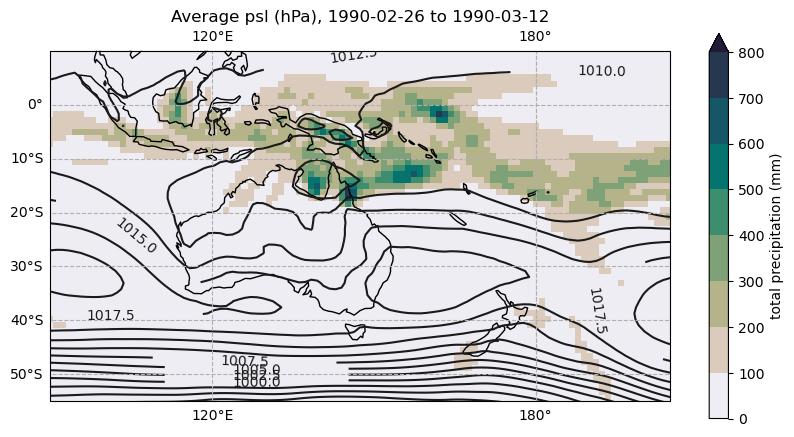

2009 (2014-03-17), member: r5i1p1f1, 644.9483525007963mm


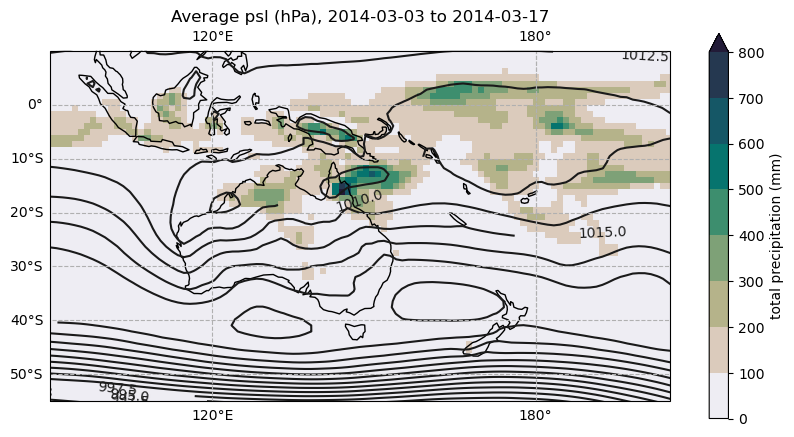

1986 (1990-03-09), member: r6i1p1f1, 622.7850272320211mm


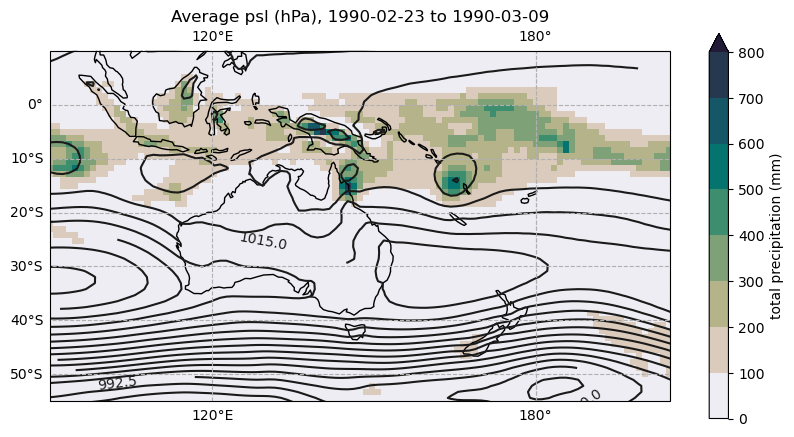

1971 (1973-02-14), member: r5i1p1f1, 483.28011855483055mm


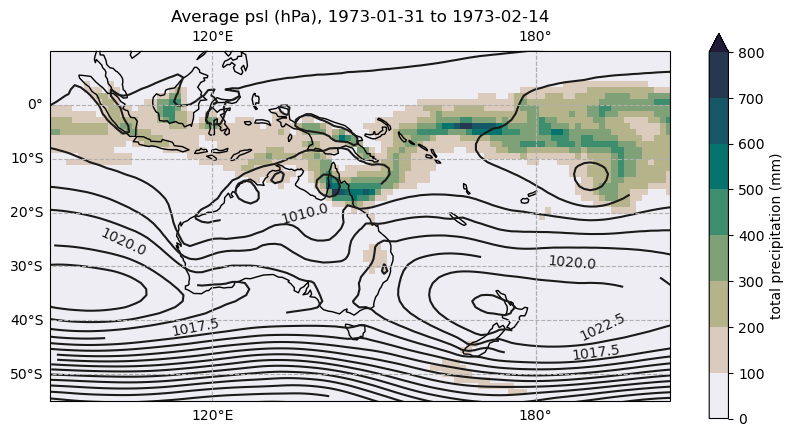

In [70]:
if model_name == 'CAFE':
    plot_cafe_meteorology(ranked_events)
else:
    plot_dcpp_meteorology(ranked_events, model_name)